## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wan-chu/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization,Dense,Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
        else:
            x = Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
    
    out = Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1,0.3,0.5]
redice_lr_patient = [2,4,6]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 patience=reduce_patient,
                                 factor=.5,
                                 min_lr=1e-12,
                                 verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 2






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 161us/step - loss: 2.1741 - acc: 0.2451 - val_loss: 1.9204 - val_acc: 0.3319
Epoch 2/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.7762 - acc: 0.3817 - val_loss: 1.7567 - val_acc: 0.3856
Epoch 3/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.6601 - acc: 0.4229 - val_loss: 1.6816 - val_acc: 0.4107
Epoch 4/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.5885 - acc: 0.4473 - val_loss: 1.6338 - val_acc: 0.4286
Epoch 5/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.5342 - acc: 0.4665 - val_loss: 1.5974 - val_acc: 0.4353
Epoch 6/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4895 - acc: 0.4825 -

50000/50000 [==============================] - 7s 131us/step - loss: 1.0808 - acc: 0.6347 - val_loss: 1.4071 - val_acc: 0.4987
Epoch 23/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.0612 - acc: 0.6436 - val_loss: 1.4033 - val_acc: 0.4995
Epoch 24/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.0396 - acc: 0.6516 - val_loss: 1.4013 - val_acc: 0.5023
Epoch 25/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.0202 - acc: 0.6581 - val_loss: 1.3991 - val_acc: 0.5022
Numbers of exp: 2, reduce_factor: 0.10, reduce_patient: 6
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 147us/step - loss: 2.1745 - acc: 0.2338 - val_loss: 1.9167 - val_acc: 0.3237
Epoch 2/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.7969 - acc: 0.3690 - val_loss: 1.7652 - val_acc: 0.3804
Epoch 3/25
50000/50000 [==============================] - 7s 132us/step 

Epoch 4/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.6009 - acc: 0.4387 - val_loss: 1.6363 - val_acc: 0.4266
Epoch 5/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.5478 - acc: 0.4582 - val_loss: 1.6006 - val_acc: 0.4384
Epoch 6/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.5035 - acc: 0.4747 - val_loss: 1.5731 - val_acc: 0.4493
Epoch 7/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.4660 - acc: 0.4890 - val_loss: 1.5488 - val_acc: 0.4558
Epoch 8/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.4313 - acc: 0.5022 - val_loss: 1.5301 - val_acc: 0.4616
Epoch 9/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3998 - acc: 0.5132 - val_loss: 1.5110 - val_acc: 0.4691
Epoch 10/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3699 - acc: 0.5256 - val_loss: 1.4965 - val_acc: 0.4737
Epoch 11/25
50000/50000 [========

50000/50000 [==============================] - 8s 165us/step - loss: 1.3262 - acc: 0.5412 - val_loss: 1.4754 - val_acc: 0.4734
Epoch 12/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.2994 - acc: 0.5519 - val_loss: 1.4655 - val_acc: 0.4771
Epoch 13/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.2737 - acc: 0.5613 - val_loss: 1.4539 - val_acc: 0.4816
Epoch 14/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.2493 - acc: 0.5708 - val_loss: 1.4453 - val_acc: 0.4855
Epoch 15/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.2250 - acc: 0.5803 - val_loss: 1.4377 - val_acc: 0.4850
Epoch 16/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2020 - acc: 0.5895 - val_loss: 1.4316 - val_acc: 0.4892
Epoch 17/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.1786 - acc: 0.5979 - val_loss: 1.4250 - val_acc: 0.4912
Epoch 18/25
50000/50000 [==============

50000/50000 [==============================] - 7s 133us/step - loss: 1.1571 - acc: 0.6061 - val_loss: 1.4113 - val_acc: 0.4977
Epoch 19/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.1351 - acc: 0.6145 - val_loss: 1.4079 - val_acc: 0.4997
Epoch 20/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.1129 - acc: 0.6241 - val_loss: 1.4020 - val_acc: 0.5043
Epoch 21/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.0921 - acc: 0.6318 - val_loss: 1.3992 - val_acc: 0.5033
Epoch 22/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.0705 - acc: 0.6399 - val_loss: 1.3972 - val_acc: 0.5060
Epoch 23/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.0499 - acc: 0.6488 - val_loss: 1.3946 - val_acc: 0.5063
Epoch 24/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.0299 - acc: 0.6573 - val_loss: 1.3933 - val_acc: 0.5062
Epoch 25/25
50000/50000 [==============

50000/50000 [==============================] - 7s 138us/step - loss: 1.7764 - acc: 0.3932 - val_loss: 1.8352 - val_acc: 0.3684
Epoch 21/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7670 - acc: 0.3961 - val_loss: 1.8265 - val_acc: 0.3730
Epoch 22/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.7571 - acc: 0.4007 - val_loss: 1.8183 - val_acc: 0.3748
Epoch 23/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.7474 - acc: 0.4046 - val_loss: 1.8102 - val_acc: 0.3778
Epoch 24/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.7390 - acc: 0.4084 - val_loss: 1.8027 - val_acc: 0.3809
Epoch 25/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.7304 - acc: 0.4111 - val_loss: 1.7954 - val_acc: 0.3839
Numbers of exp: 11, reduce_factor: 0.10, reduce_patient: 6
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 175us/st

Epoch 2/25
50000/50000 [==============================] - 7s 137us/step - loss: 2.1773 - acc: 0.2308 - val_loss: 2.1148 - val_acc: 0.2540
Epoch 3/25
50000/50000 [==============================] - 7s 137us/step - loss: 2.0625 - acc: 0.2707 - val_loss: 2.0331 - val_acc: 0.2823
Epoch 4/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.9934 - acc: 0.2957 - val_loss: 1.9793 - val_acc: 0.3007
Epoch 5/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.9440 - acc: 0.3133 - val_loss: 1.9403 - val_acc: 0.3148
Epoch 6/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.9059 - acc: 0.3278 - val_loss: 1.9096 - val_acc: 0.3277
Epoch 7/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.8749 - acc: 0.3394 - val_loss: 1.8843 - val_acc: 0.3385
Epoch 8/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.8486 - acc: 0.3497 - val_loss: 1.8630 - val_acc: 0.3448
Epoch 9/25
50000/50000 [==========

50000/50000 [==============================] - 7s 137us/step - loss: 1.8114 - acc: 0.3706 - val_loss: 1.8360 - val_acc: 0.3608
Epoch 10/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7940 - acc: 0.3762 - val_loss: 1.8217 - val_acc: 0.3648
Epoch 11/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7772 - acc: 0.3821 - val_loss: 1.8087 - val_acc: 0.3711
Epoch 12/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.7634 - acc: 0.3878 - val_loss: 1.7973 - val_acc: 0.3746
Epoch 13/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7495 - acc: 0.3928 - val_loss: 1.7866 - val_acc: 0.3765
Epoch 14/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7384 - acc: 0.3967 - val_loss: 1.7767 - val_acc: 0.3793
Epoch 15/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7265 - acc: 0.4023 - val_loss: 1.7677 - val_acc: 0.3832
Epoch 16/25
50000/50000 [==============

50000/50000 [==============================] - 7s 136us/step - loss: 1.7446 - acc: 0.4049 - val_loss: 1.7941 - val_acc: 0.3867
Epoch 17/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.7336 - acc: 0.4095 - val_loss: 1.7854 - val_acc: 0.3895
Epoch 18/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.7236 - acc: 0.4132 - val_loss: 1.7772 - val_acc: 0.3923
Epoch 19/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.7130 - acc: 0.4160 - val_loss: 1.7693 - val_acc: 0.3959
Epoch 20/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7049 - acc: 0.4200 - val_loss: 1.7619 - val_acc: 0.3980
Epoch 21/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6959 - acc: 0.4229 - val_loss: 1.7545 - val_acc: 0.4012
Epoch 22/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6877 - acc: 0.4262 - val_loss: 1.7480 - val_acc: 0.4020
Epoch 23/25
50000/50000 [==============

50000/50000 [==============================] - 7s 133us/step - loss: 1.8968 - acc: 0.3470 - val_loss: 1.9334 - val_acc: 0.3390
Epoch 19/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8815 - acc: 0.3507 - val_loss: 1.9195 - val_acc: 0.3448
Epoch 20/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8667 - acc: 0.3563 - val_loss: 1.9063 - val_acc: 0.3505
Epoch 21/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8532 - acc: 0.3613 - val_loss: 1.8939 - val_acc: 0.3539
Epoch 22/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8400 - acc: 0.3640 - val_loss: 1.8822 - val_acc: 0.3560
Epoch 23/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8279 - acc: 0.3688 - val_loss: 1.8711 - val_acc: 0.3601
Epoch 24/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.8165 - acc: 0.3725 - val_loss: 1.8607 - val_acc: 0.3625
Epoch 25/25
50000/50000 [==============

50000/50000 [==============================] - 7s 133us/step - loss: 1.7816 - acc: 0.3840 - val_loss: 1.8132 - val_acc: 0.3690
Numbers of exp: 22, reduce_factor: 0.30, reduce_patient: 4
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 194us/step - loss: 2.6070 - acc: 0.1216 - val_loss: 2.5363 - val_acc: 0.1354
Epoch 2/25
50000/50000 [==============================] - 7s 135us/step - loss: 2.5034 - acc: 0.1397 - val_loss: 2.4471 - val_acc: 0.1538
Epoch 3/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.4197 - acc: 0.1600 - val_loss: 2.3750 - val_acc: 0.1733
Epoch 4/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.3506 - acc: 0.1791 - val_loss: 2.3162 - val_acc: 0.1923
Epoch 5/25
50000/50000 [==============================] - 7s 135us/step - loss: 2.2916 - acc: 0.2001 - val_loss: 2.2668 - val_acc: 0.2103
Epoch 6/25
50000/50000 [==============================] - 7s 134us/step -

Epoch 7/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.1603 - acc: 0.2470 - val_loss: 2.1543 - val_acc: 0.2536
Epoch 8/25
50000/50000 [==============================] - 7s 133us/step - loss: 2.1204 - acc: 0.2593 - val_loss: 2.1179 - val_acc: 0.2632
Epoch 9/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.0855 - acc: 0.2692 - val_loss: 2.0852 - val_acc: 0.2742
Epoch 10/25
50000/50000 [==============================] - 7s 133us/step - loss: 2.0537 - acc: 0.2807 - val_loss: 2.0561 - val_acc: 0.2838
Epoch 11/25
50000/50000 [==============================] - 7s 133us/step - loss: 2.0251 - acc: 0.2896 - val_loss: 2.0299 - val_acc: 0.2938
Epoch 12/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.9988 - acc: 0.2992 - val_loss: 2.0053 - val_acc: 0.3015
Epoch 13/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.9749 - acc: 0.3070 - val_loss: 1.9830 - val_acc: 0.3071
Epoch 14/25
50000/50000 [=====

50000/50000 [==============================] - 7s 136us/step - loss: 1.9743 - acc: 0.2963 - val_loss: 1.9800 - val_acc: 0.2987
Epoch 15/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.9529 - acc: 0.3050 - val_loss: 1.9620 - val_acc: 0.3028
Epoch 16/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.9345 - acc: 0.3115 - val_loss: 1.9451 - val_acc: 0.3093
Epoch 17/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.9164 - acc: 0.3186 - val_loss: 1.9296 - val_acc: 0.3148
Epoch 18/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.8996 - acc: 0.3242 - val_loss: 1.9151 - val_acc: 0.3199
Epoch 19/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.8837 - acc: 0.3311 - val_loss: 1.9014 - val_acc: 0.3257
Epoch 20/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.8688 - acc: 0.3359 - val_loss: 1.8885 - val_acc: 0.3308
Epoch 21/25
50000/50000 [==============

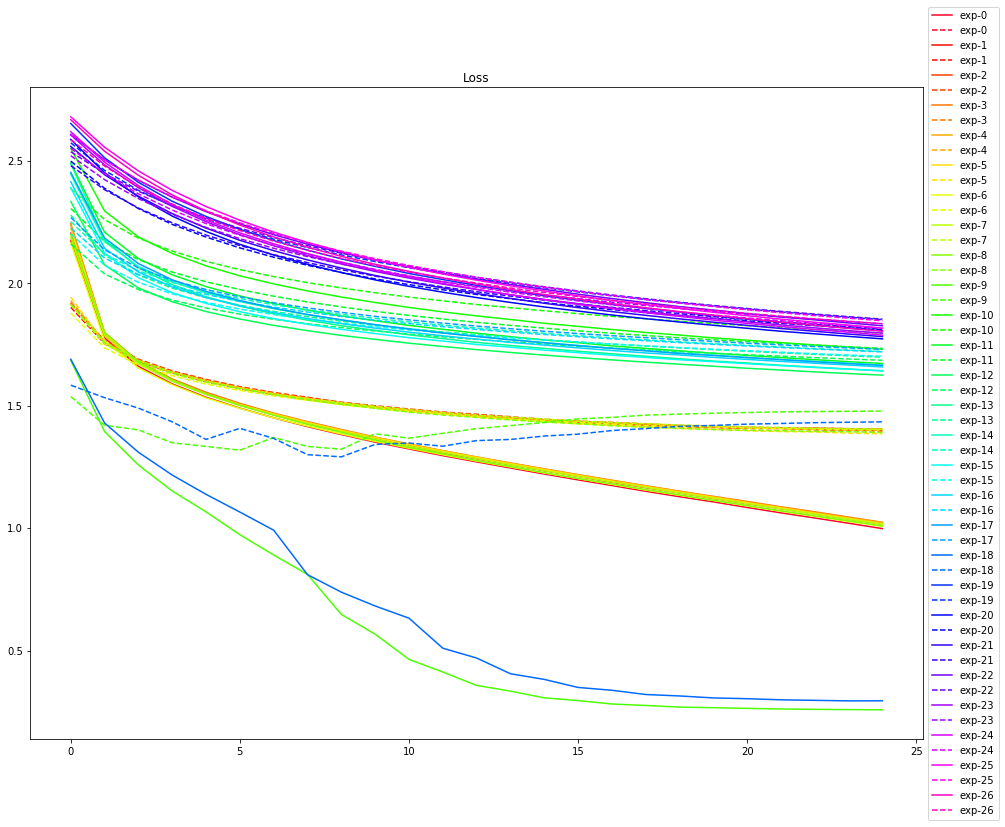

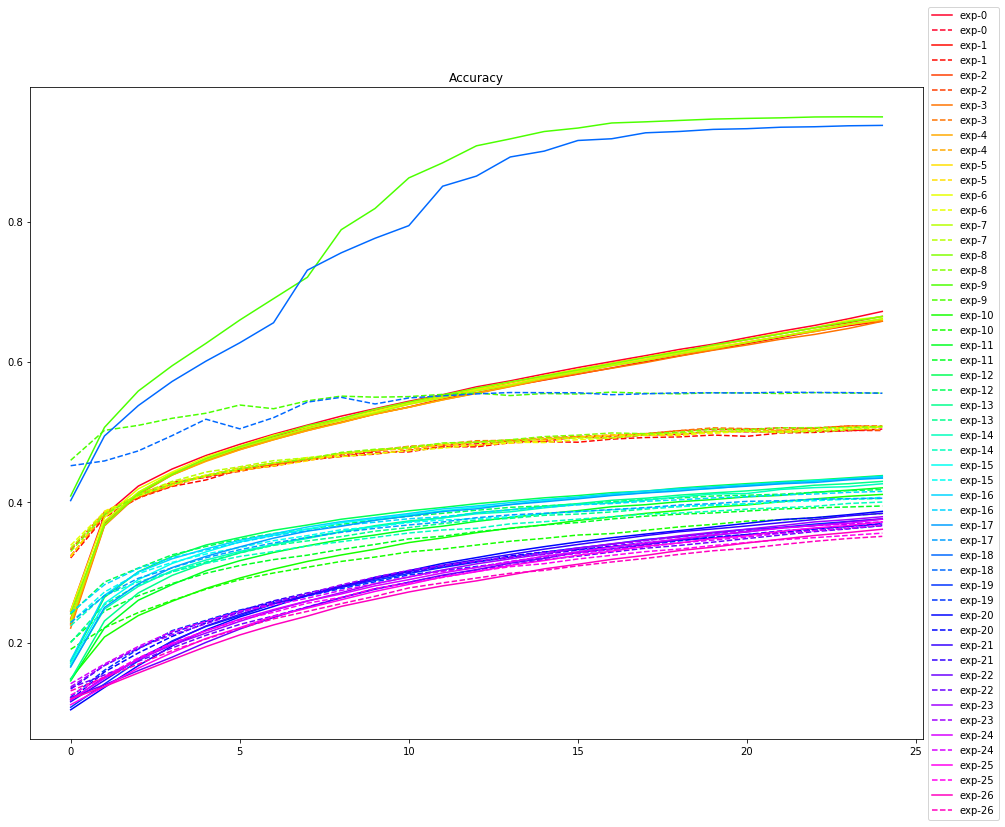

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()